In [ ]:
!pip install pandas
!pip install pymystem3
!pip install numpy
!pip install matplotlib


In [57]:
%matplotlib inline
import re
import requests
import urllib.request
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem


In [5]:
API_ENDPOINT = 'https://api.vk.com/method/'
API_VERSION = '5.95'
ACCESS_TOKEN = 'da62c274da62c274da62c27431da08963bdd' \
               'a62da62c27486a8d75af3885f3e56368096'

COMMUNITY_URL = 'https://vk.com/public150709625'
COMMUNITY_ID = -150709625


In [6]:
def get_comments(wall_id_list, n_comments=10):
    mystem = Mystem()

    with open('obscene.txt', 'r') as file:
        obscene = file.read().lower().split('\n')[:-2]

    with open('stopword.txt', 'r') as file:
        stopwords = file.read().split('\n')[:-1]

    offset = 100
    n_iterations = n_comments // offset
    remainder = n_comments % offset

    comment_request = API_ENDPOINT + 'wall.getComments' + '?'

    comment_data = []
    for wall_id in wall_id_list:
        comments = []
        for i in range(n_iterations):
            iter_comment_request = comment_request
            iter_comment_params = 'owner_id={}&post_id={}&offset={}&count={}'\
                .format(COMMUNITY_ID, wall_id,
                        offset * i, offset)
            iter_comment_request += iter_comment_params
            iter_comment_request += '&access_token={}&v={}'\
                .format(ACCESS_TOKEN, API_VERSION)
            iter_response = requests.post(url=iter_comment_request)\
                .json()['response']['items']

            for j in range(len(iter_response)):
                item = {}
                if 'deleted' not in iter_response[j].keys():
                    for key in ['from_id', 'text']:
                        item[key] = iter_response[j][key]
                    comments.append(item)

        if remainder:
            remainder_comment_request = comment_request
            remainder_comment_params = 'owner_id={}&post_id={}' \
                                       '&offset={}&count={}'\
                .format(COMMUNITY_ID, wall_id,
                        offset * n_iterations,
                        remainder)
            remainder_comment_request += remainder_comment_params
            remainder_comment_request += '&access_token={}&v={}'\
                .format(ACCESS_TOKEN, API_VERSION)
            remainder_responses = requests.post(url=remainder_comment_request)\
                .json()['response']['items']

            for i in range(len(remainder_responses)):
                item = {}
                if 'deleted' not in remainder_responses[i].keys():
                    for key in ['from_id', 'text']:
                        item[key] = remainder_responses[i][key]
                    comments.append(item)

        for comment in comments:
            comment['text'] = comment['text'].lower()
            comment['text'] = re.sub('[^а-я]', ' ', comment['text'])

            comment['text'] = re.sub(' +', ' ', comment['text'])

            lemmas = mystem.lemmatize(comment['text'])
            comment['lemmatized'] = ''.join(lemmas)[:-1]

            comment['lemmatized_no_obscene'] = comment['lemmatized']
            for word in obscene:
                comment['lemmatized_no_obscene'] =\
                    (' ' + comment['lemmatized_no_obscene'] + ' ')\
                    .replace(' %s ' % word, ' ').strip()

            comment['lemmatized'] = comment['lemmatized_no_obscene']
            del comment['lemmatized_no_obscene']

            comment['text_nostopw'] = comment['text']
            comment['lemmatized_nostopw'] = comment['lemmatized']

            for stopword in stopwords:
                comment['lemmatized_nostopw'] =\
                    (' ' + comment['lemmatized_nostopw'] + ' ') \
                    .replace(' %s ' % stopword, ' ').strip()
                comment['text_nostopw'] =\
                    (' ' + comment['text_nostopw'] + ' ')\
                    .replace(' %s ' % stopword, ' ').strip()

            comment['len'] = len(comment['text'].split())
            comment['wall_id'] = wall_id

        comment_len = 0

        for i in range(len(comments)):
            comment_len += comments[i]['len']

        try:
            post_comment_len_mean = comment_len / len(comments)
        except ZeroDivisionError:
            continue

        for comment in comments:
            comment['post_comment_len_mean'] = post_comment_len_mean

        comment_data.append(comments)

    user_ids = []
    for i in range(len(comment_data)):
        for j in range(len(comment_data[i])):
            user_ids.append(str(comment_data[i][j]['from_id']))

    name2gender = {}

    with open('name2gender.txt', 'r') as file:
        names = file.read().split('\n')
        for name in names[:-1]:
            n, g = name.split()
            name2gender[n] = g

    user_data = []
    for uid in user_ids:
        try:
            html_file = urllib.request.urlopen('https://vk.com/id{}'
                                               .format(uid))
            html_bytes = html_file.read()
            html_file.close()
            html_str = html_bytes.decode('utf8').lower()

            name = html_str.split('title>')[1][:-2]

            if name != 'ВКонтакте':
                city = html_str.split('pp_info">')[1].split('</div>')[0]
            else:
                continue

            first_name = name.split()[0]

            gender = name2gender.get(first_name)
            if gender is None:
                continue

            city = city.split()[-1]

            user_data.append({'uid': uid, 'name': name,
                              'gender': gender, 'city': city})
        except Exception:
            continue

    for user in user_data:
        if user['city'] in ['', 'лет', 'года', 'год', 'deleted']:
            user_data.remove(user)

    flat_comment_list = []
    for com_data in comment_data:
        for item in com_data:
            flat_comment_list.append(item)

    return flat_comment_list, user_data


In [7]:
def get_walls(n_walls=1):
    offset = 100
    n_iterations = n_walls // offset
    remainder = n_walls % offset

    wall_request = API_ENDPOINT + 'wall.get' + '?'

    wall_data = []
    wall_ids = []
    for i in range(n_iterations):
        iter_wall_request = wall_request
        iter_wall_params = 'owner_id={}&offset={}&count={}'\
            .format(COMMUNITY_ID, offset * i, offset)
        iter_wall_request += iter_wall_params
        iter_wall_request += '&access_token={}&v={}'.format(ACCESS_TOKEN,
                                                            API_VERSION)
        iter_response =\
            requests.post(url=iter_wall_request).json()['response']['items']

        iter_wall_data = []
        iter_wall_ids = []
        for i in range(len(iter_response)):
            item = {}
            for key in ['id', 'date', 'text']:
                item[key] = iter_response[i][key]
            iter_wall_data.append(item)
            iter_wall_ids.append(item['id'])
        for item in iter_wall_data:
            wall_data.append(item)
        for item in iter_wall_ids:
            wall_ids.append(item)

    remainder_wall_request = wall_request
    remainder_wall_params =\
        'owner_id={}&offset={}&count={}'.format(COMMUNITY_ID,
                                                offset * n_iterations,
                                                remainder)
    remainder_wall_request += remainder_wall_params
    remainder_wall_request += '&access_token={}&v={}'.format(ACCESS_TOKEN,
                                                             API_VERSION)

    remainder_response =\
        requests.post(url=remainder_wall_request).json()['response']['items']
    remainder_wall_data = []
    remainder_wall_ids = []
    for i in range(len(remainder_response)):
        item = {}
        for key in ['id', 'date', 'text']:
            item[key] = remainder_response[i][key]
        remainder_wall_data.append(item)
        remainder_wall_ids.append(item['id'])

    for item in remainder_wall_data:
        wall_data.append(item)
    for item in remainder_wall_ids:
        wall_ids.append(item)

    mystem = Mystem()

    with open('stopword.txt', 'r') as file:
        stopwords = file.read().split('\n')[:-1]

    wall_len = 0

    for wall_d in wall_data:
        wall_d['text'] = wall_d['text'].lower()
        wall_d['text'] = re.sub('[^а-я]', ' ', wall_d['text'])

        wall_d['text'] = re.sub(' +', ' ', wall_d['text'])

        lemmas = mystem.lemmatize(wall_d['text'])
        wall_d['lemmatized'] = ''.join(lemmas)[:-1]

        wall_d['text_nostopw'] = wall_d['text']
        wall_d['lemmatized_nostopw'] = wall_d['lemmatized']

        for stopword in stopwords:
            wall_d['text_nostopw'] = (' ' + wall_d['text_nostopw'] + ' ')\
                .replace(' %s ' % stopword, ' ').strip()

            wall_d['lemmatized_nostopw'] =\
                (' ' + wall_d['lemmatized_nostopw'] + ' ')\
                .replace(' %s ' % stopword, ' ').strip()

        wall_d['len'] = len(wall_d['text'].split())

        wall_d['month'] =\
            datetime.utcfromtimestamp(wall_d['date']).strftime('%m')
        wall_d['year'] =\
            datetime.utcfromtimestamp(wall_d['date']).strftime('%Y')

        wall_len += wall_d['len']

    wall_len_mean = wall_len / len(wall_data)

    return wall_ids, wall_data, wall_len_mean


In [ ]:
walls_id, walls, wlen_mean = get_walls(101)

comment_dat, u_data = get_comments(walls_id, 101)

user_dataframe = pd.DataFrame(u_data)
wall_dataframe = pd.DataFrame(walls)
comment_dataframe = pd.DataFrame(comment_dat)

user_dataframe.to_csv('user101w101c.csv')
wall_dataframe.to_csv('wall101w101c.csv')
comment_dataframe.to_csv('comment101w101c.csv')


In [62]:
print('Средняя длина поста в словах: %i' % wlen_mean)  

Средняя длина поста в словах: 108


In [63]:
user_dataframe = pd.read_csv('user128w128c.csv', index_col=0)
wall_dataframe = pd.read_csv('wall128w128c.csv', index_col=0)
comment_dataframe = pd.read_csv('comment128w128c.csv', index_col=0)

comment_dataframe.dropna(inplace=True)
wall_dataframe.dropna(inplace=True)
user_dataframe.dropna(inplace=True)
comment_dataframe.drop_duplicates(inplace=True)
wall_dataframe.drop_duplicates(inplace=True)
user_dataframe.drop_duplicates(inplace=True)

In [64]:
user_dataframe.head()

,city,gender,name,uid
0,тамбов,m,роман пищальников,211145668
1,санкт-петербург,f,мария тише,243426800
2,санкт-петербург,m,олег красилов,959451
3,москва,f,наталья пенькова,319469008
4,москва,f,анна работа,542599886


In [65]:
wall_dataframe.head()

,date,id,lemmatized,lemmatized_nostopw,len,month,text,text_nostopw,year
0,1557003765,3549290,пожалуй это самый жестокий история который у м...,пожалуй жестокий история публиковаться сообщат...,96,5,пожалуй это самая жестокая история которая у н...,пожалуй самая жестокая история публиковалась с...,2019
1,1557162757,3561368,бойцовый алабай загрызать прохожий шокировать ...,бойцовый алабай загрызать прохожий шокировать ...,120,5,бойцовый алабай загрыз прохожего шокирующая но...,бойцовый алабай загрыз прохожего шокирующая но...,2019
2,1557152700,3560626,в нижний новгород находить мертвый пропадать р...,нижний новгород находить мертвый пропадать ран...,105,5,в нижнем новгороде нашли мертвой пропавшую ран...,нижнем новгороде нашли мертвой пропавшую ранее...,2019
3,1557144007,3560043,российский чиновник устраивать себя выходной в...,российский чиновник устраивать выходной честь ...,111,5,российские чиновники устроили себе выходной в ...,российские чиновники устроили выходной честь д...,2019
4,1557140402,3559828,написать бот что бы получать первый заем без ...,написать бот получать заем процент переплата ч...,19,5,напиши боту что бы получить первый займ без п...,напиши боту займ переплат честно условия юриди...,2019


In [66]:
comment_dataframe.head()

,from_id,lemmatized,lemmatized_nostopw,len,post_comment_len_mean,text,text_nostopw,wall_id
0,211145668,это какой то дичь откуда браться настолько жес...,дичь браться настолько жестокий смертный казнь...,19,9.488,это какая то дичь откуда берутся настолько жес...,дичь берутся настолько жестокие ублюдки смертн...,3549290
1,540918832,год забавно хороший суд у мы просто хороший,забавно суд,8,9.488,лет забавно хороший суд у нас просто лучший,забавно суд лучший,3549290
2,243426800,год ахах это раися,ахах раися,4,9.488,лет ахаха это раися,ахаха раися,3549290
3,537615469,все вот это шуточка,шуточка,4,9.488,всего вот это шуточка,шуточка,3549290
4,184616806,да за это минимум пожизненный надо давать не в...,минимум пожизненный школьник пойд закладка пло...,55,9.488,да за это минимум пожизненное надо давать не в...,минимум пожизненное подумайте школьник пойд за...,3549290


In [67]:
wall_plain_text = ' '.join(wall_dataframe.text)
comment_plain_text = ' '.join(comment_dataframe.text)

plain_text = wall_plain_text + ' ' + comment_plain_text

with open("plain128w128c.txt", "w") as text_file:
    text_file.write(plain_text)

In [68]:
wall_plain_text_nostopw = ' '.join(wall_dataframe.text_nostopw)
comment_plain_text_nostopw = ' '.join(comment_dataframe.text_nostopw)

plain_text_nostopw = wall_plain_text_nostopw\
    + ' ' + comment_plain_text_nostopw

with open("plain128w128c_nostopw.txt", "w") as text_file:
    text_file.write(plain_text_nostopw)

In [69]:
wall_lemmatized_nostopw =\
    ' '.join(wall_dataframe.lemmatized_nostopw)
comment_lemmatized_nostopw =\
    ' '.join(comment_dataframe.lemmatized_nostopw)

lemmatized_nostopw = wall_lemmatized_nostopw\
    + ' ' + comment_lemmatized_nostopw

with open("lemmatized128w128c_nostopw.txt", "w") as text_file:
    text_file.write(lemmatized_nostopw)

In [70]:
wall_lemmatized_text = ' '.join(wall_dataframe.lemmatized)
comment_lemmatized_text = ' '.join(comment_dataframe.lemmatized)

lemmatized_text = wall_lemmatized_text + ' ' + comment_lemmatized_text

with open("lemmatized128w128c.txt", "w") as text_file:
    text_file.write(lemmatized_text)

In [72]:
comment_mean_length =\
    round(np.sum(comment_dataframe.len) / len(comment_dataframe))
print('Средняя длина комментария в словах: %i '
      % comment_mean_length)

Средняя длина комментария в словах: 13 


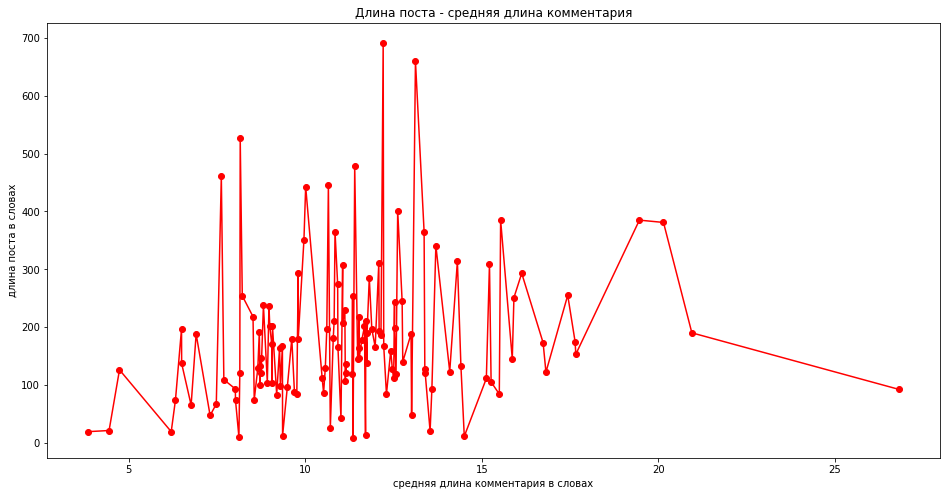

In [73]:
# График 1: Длина поста - средняя длина комментария
x_1 = []
y_1 = []
for wall_id in wall_dataframe.id.values:
    try:
        y_1.append(wall_dataframe[wall_dataframe.id ==
                                  wall_id].len.values[0])
        x_1.append(comment_dataframe[comment_dataframe.wall_id ==
                                     wall_id].post_comment_len_mean.
                   values[0])
    except IndexError:
        y_1.pop()
        continue
        
x_1 = np.array(x_1)
y_1 = np.array(y_1)
idx_1 = x_1.argsort()

plt.rcParams['figure.figsize'] = (16, 8)
plt.plot(x_1[idx_1], y_1[idx_1], 'ro-')
plt.title('Длина поста - средняя длина комментария')
plt.xlabel('средняя длина комментария в словах')
plt.ylabel('длина поста в словах')
plt.savefig('wall_len-com_len_mean.png')
plt.show()


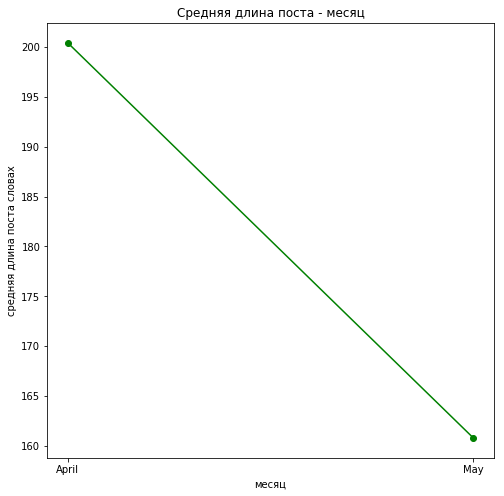

In [74]:
# График 2: Средняя длина поста - месяц
x_2 = wall_dataframe.month.unique()[::-1]
y_2 = []
for month in x_2:
    y_2.append(wall_dataframe[wall_dataframe.month ==
                              month].len.values.mean())

x_2 = np.array(['April', 'May'])
y_2 = np.array(y_2)

plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(x_2, y_2, 'go-')
plt.title('Средняя длина поста - месяц')
plt.ylabel('средняя длина поста словах')
plt.xlabel('месяц')
plt.savefig('wall_len_mean-month.png')
plt.show()

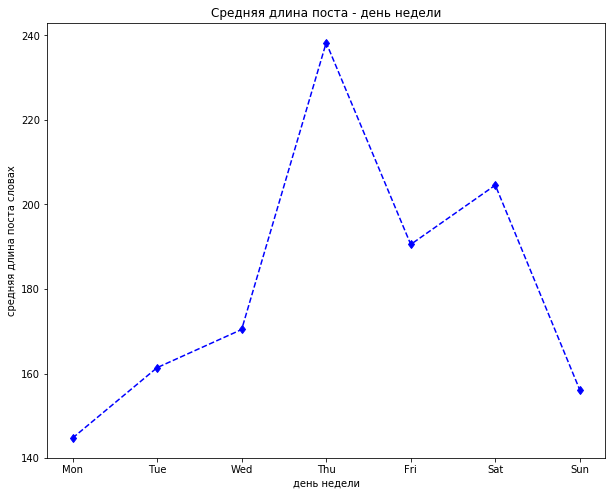

In [76]:
# График 3: Средняя длина поста - день недели
weekday = [datetime.utcfromtimestamp(wall_dataframe.date.values[i])
           .strftime('%a') for i in range(len(wall_dataframe))]
wall_dataframe['weekday'] = weekday
weekdays = ['Mon', 'Tue', 'Wed', 'Thu',
            'Fri', 'Sat', 'Sun']

x_3 = np.array(weekdays)
y_3 = []
for weekday in weekdays:
    y_3.append(wall_dataframe[wall_dataframe.weekday ==
                              weekday].len.values.mean())
y_3 = np.array(y_3)

plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(x_3, y_3, 'bd--')
plt.title('Средняя длина поста - день недели')
plt.ylabel('средняя длина поста словах')
plt.xlabel('день недели')
plt.savefig('wall_len_mean-weekday.png')
plt.show()

In [77]:
uids = user_dataframe.uid.values

user_comments_len_mean = []
for uid in uids:
    user_comments_len_mean.append(comment_dataframe
                                  [comment_dataframe.from_id ==
                                   uid].len.values.mean())

user_comments_len_mean = np.array(user_comments_len_mean)
idx = np.isnan(user_comments_len_mean)
user_comments_len_mean[idx] = 0

user_dataframe['user_comments_len_mean'] =\
    user_comments_len_mean

/home/nevermind/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


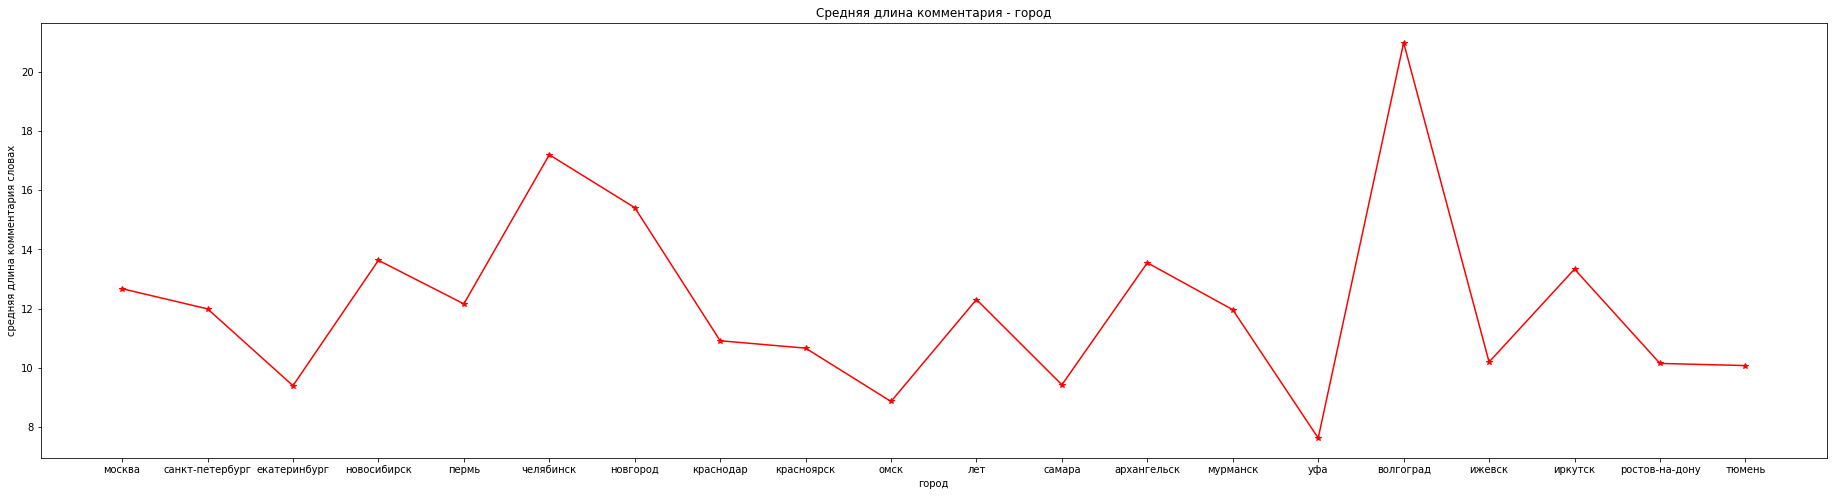

In [78]:
# График 4: Средняя длина комментария - город
x_4 = user_dataframe.city.value_counts().keys()[:20].values
x_4 = np.array(x_4)
y_4 = []
for city in x_4:
    y_4.append(user_dataframe[user_dataframe.city == city]
               .user_comments_len_mean.values.mean())

y_4 = np.array(y_4)

plt.rcParams["figure.figsize"] = [32, 8]
plt.plot(x_4, y_4, 'r*-')
plt.title('Средняя длина комментария - город')
plt.ylabel('средняя длина комментария словах')
plt.xlabel('город')
plt.savefig('com_len_mean-city.png')
plt.show()

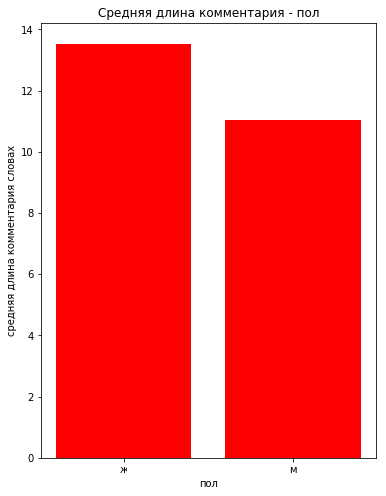

In [79]:
# График 5: Средняя длина комментария - пол
x_5 = np.array(['f', 'm'])
y_5 = []
for x in x_5:
    y_5.append(user_dataframe[user_dataframe.gender == x]
               .user_comments_len_mean.values.mean())

y_5 = np.array(y_5)
x_5 = np.array(['ж', 'м'])

plt.rcParams["figure.figsize"] = [6, 8]
plt.bar(x_5, y_5, color='red')
plt.title('Средняя длина комментария - пол')
plt.ylabel('средняя длина комментария словах')
plt.xlabel('пол')
plt.savefig('com_len_mean-gender.png')
plt.show()

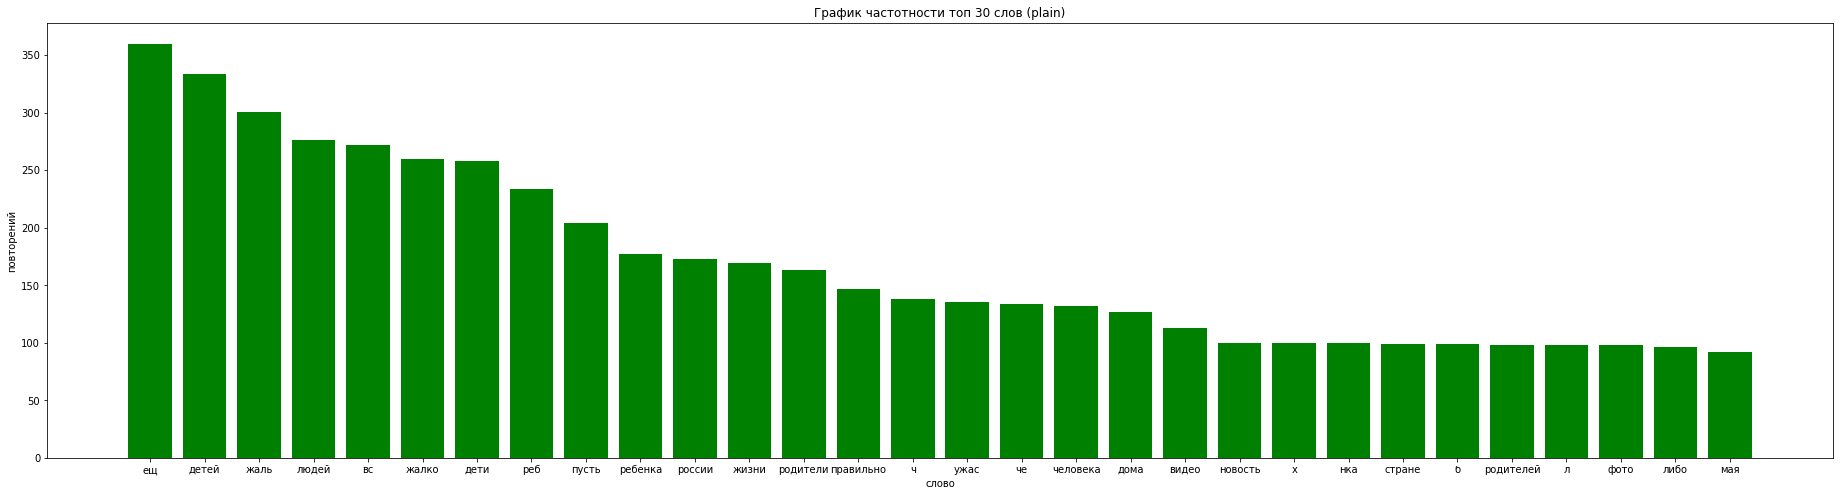

In [80]:
# График 6: График частотности топ 30 слов (plain)
with open('plain128w128c_nostopw.txt', 'r') as file:
    plain = np.array(file.read().split())

words, count = np.unique(plain, return_counts=True)
idx = count.argsort()[::-1]
y_6 = count[idx][:30]
x_6 = words[idx][:30]

plt.rcParams["figure.figsize"] = [32, 8]
plt.bar(x_6, y_6, color='green')
plt.title('График частотности топ 30 слов (plain)')
plt.ylabel('повторений')
plt.xlabel('слово')
plt.savefig('top30plain.png', bbox_inches='tight')
plt.show()

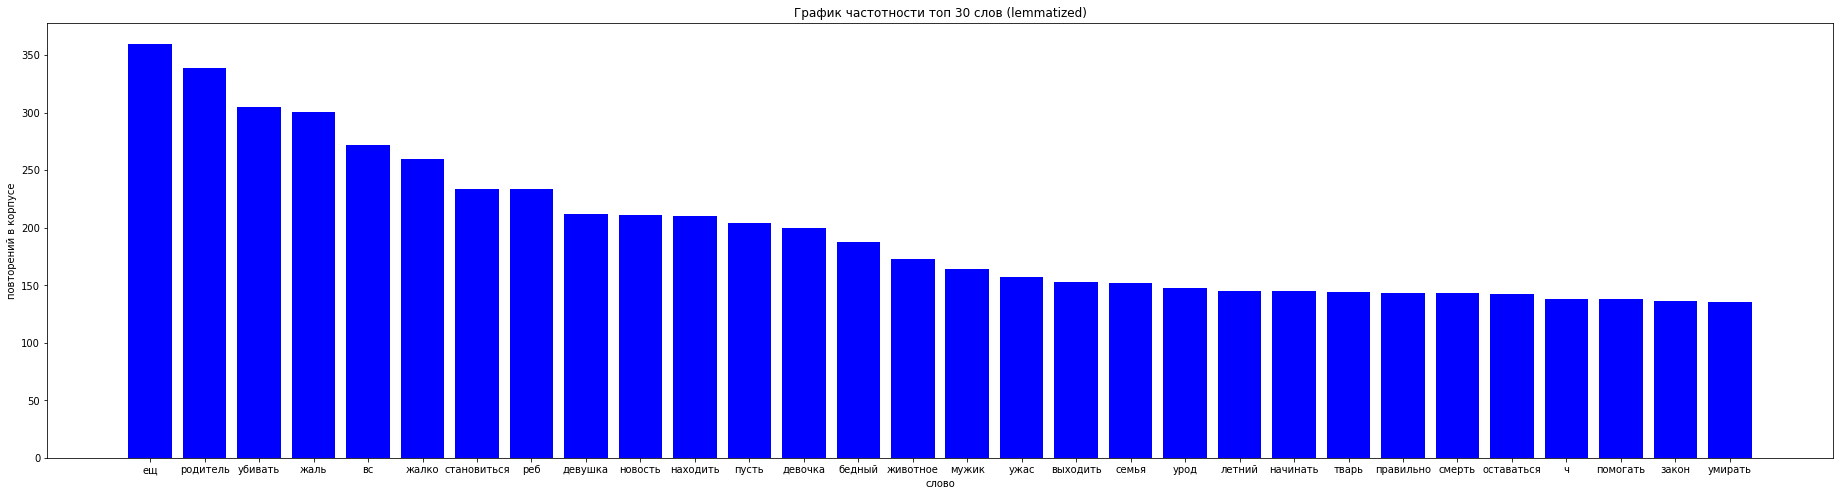

In [81]:
# График 7: График частотности топ 30 слов (lemmatized)
with open('lemmatized128w128c_nostopw.txt', 'r') as file:
    lemmatized = np.array(file.read().split())

words_l, count_l = np.unique(lemmatized, return_counts=True)
idx_l = count_l.argsort()[::-1]
y_7 = count_l[idx_l][:30]
x_7 = words_l[idx_l][:30]

plt.bar(x_7, y_7, color='blue')
plt.title('График частотности топ 30 слов (lemmatized)')
plt.ylabel('повторений в корпусе')
plt.xlabel('слово')
plt.savefig('top30lemmatized.png', bbox_inches='tight')
plt.show()